In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import lasagne
from parmesan.distributions import log_bernoulli, kl_normal2_stdnormal
from parmesan.layers import SimpleSampleLayer
from keras.datasets import mnist
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from read_write_model import read_model, write_model

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '1455944' (I am process '2024334')
Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)
Using Theano backend.


In [2]:
#settings
do_train_model = False
batch_size = 100
latent_size = 20
nhidden = 512
lr = 0.001
num_epochs = 50
model_filename = "mnist_vae"
nonlin = lasagne.nonlinearities.rectify

np.random.seed(1234) # reproducibility

In [3]:
#SYMBOLIC VARS
sym_x = T.matrix()
sym_lr = T.scalar('lr')

### LOAD DATA
print "Using MNIST dataset"

(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x = (train_x.reshape((-1, 784))/255.0).astype(np.float32)
test_x = (test_x.reshape((-1, 784))/255.0).astype(np.float32)

train_x[train_x > 0.5] = 1.0
train_x[train_x <= 0.5] = 0.0

train_x[train_x > 0.5] = 1.0
train_x[train_x <= 0.5] = 0.0

#setup shared variables
sh_x_train = theano.shared(train_x, borrow=True)
sh_x_test = theano.shared(test_x, borrow=True)

nfeatures=train_x.shape[1]
n_train_batches = train_x.shape[0] / batch_size
n_test_batches = test_x.shape[0] / batch_size

Using MNIST dataset


In [4]:
### RECOGNITION MODEL q(z|x)
l_in = lasagne.layers.InputLayer((batch_size, nfeatures))
l_noise = lasagne.layers.BiasLayer(l_in, b = np.zeros(nfeatures, dtype = np.float32), name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
l_enc_h1 = lasagne.layers.DenseLayer(l_noise, num_units=nhidden, nonlinearity=nonlin, name='ENC_DENSE1')
l_enc_h1 = lasagne.layers.DenseLayer(l_enc_h1, num_units=nhidden, nonlinearity=nonlin, name='ENC_DENSE2')

l_mu = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='ENC_Z_MU')
l_log_var = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='ENC_Z_LOG_VAR')

#sample the latent variables using mu(x) and log(sigma^2(x))
l_z = SimpleSampleLayer(mean=l_mu, log_var=l_log_var)

In [5]:
### GENERATIVE MODEL p(x|z)
l_dec_h1 = lasagne.layers.DenseLayer(l_z, num_units=nhidden, nonlinearity=nonlin, name='DEC_DENSE2')
l_dec_h1 = lasagne.layers.DenseLayer(l_dec_h1, num_units=nhidden, nonlinearity=nonlin, name='DEC_DENSE1')
l_dec_x_mu = lasagne.layers.DenseLayer(l_dec_h1, num_units=nfeatures, nonlinearity=lasagne.nonlinearities.sigmoid, name='DEC_X_MU')

# Get outputs from model
# with noise
z_train, z_mu_train, z_log_var_train, x_mu_train = lasagne.layers.get_output(
    [l_z, l_mu, l_log_var, l_dec_x_mu], sym_x, deterministic=False
)

# without noise
z_eval, z_mu_eval, z_log_var_eval, x_mu_eval = lasagne.layers.get_output(
    [l_z, l_mu, l_log_var, l_dec_x_mu], sym_x, deterministic=True
)

In [6]:
#Calculate the loglikelihood(x) = E_q[ log p(x|z) + log p(z) - log q(z|x)]
def ELBO(z, z_mu, z_log_var, x_mu, x):
    """
    Latent z       : gaussian with standard normal prior
    decoder output : bernoulli

    When the output is bernoulli then the output from the decoder
    should be sigmoid. The sizes of the inputs are
    z: (batch_size, num_latent)
    z_mu: (batch_size, num_latent)
    z_log_var: (batch_size, num_latent)
    x_mu: (batch_size, num_features)
    x: (batch_size, num_features)
    """
    kl_term = kl_normal2_stdnormal(z_mu, z_log_var).sum(axis=1)
    log_px_given_z = log_bernoulli(x, x_mu, eps=1e-6).sum(axis=1)
    LL = T.mean(-kl_term + log_px_given_z)

    return LL

# TRAINING LogLikelihood
LL_train = ELBO(z_train, z_mu_train, z_log_var_train, x_mu_train, sym_x)

# EVAL LogLikelihood
LL_eval = ELBO(z_eval, z_mu_eval, z_log_var_eval, x_mu_eval, sym_x)

params = lasagne.layers.get_all_params(l_dec_x_mu, trainable=True)
for p in params:
    print p, p.get_value().shape

### Take gradient of Negative LogLikelihood
grads = T.grad(-LL_train, params)

# Add gradclipping to reduce the effects of exploding gradients.
# This speeds up convergence
clip_grad = 1
max_norm = 5
mgrads = lasagne.updates.total_norm_constraint(grads,max_norm=max_norm)
cgrads = [T.clip(g,-clip_grad, clip_grad) for g in mgrads]

ENC_DENSE1.W (784, 512)
ENC_DENSE1.b (512,)
ENC_DENSE2.W (512, 512)
ENC_DENSE2.b (512,)
ENC_Z_MU.W (512, 20)
ENC_Z_MU.b (20,)
ENC_Z_LOG_VAR.W (512, 20)
ENC_Z_LOG_VAR.b (20,)
DEC_DENSE2.W (20, 512)
DEC_DENSE2.b (512,)
DEC_DENSE1.W (512, 512)
DEC_DENSE1.b (512,)
DEC_X_MU.W (512, 784)
DEC_X_MU.b (784,)


In [7]:
#Setup the theano functions
sym_batch_index = T.iscalar('index')
batch_slice = slice(sym_batch_index * batch_size, (sym_batch_index + 1) * batch_size)

updates = lasagne.updates.adam(cgrads, params, learning_rate=sym_lr)

train_model = theano.function([sym_batch_index, sym_lr], LL_train, updates=updates,
                                  givens={sym_x: sh_x_train[batch_slice]},)

test_model = theano.function([sym_batch_index], LL_eval,
                                  givens={sym_x: sh_x_test[batch_slice]},)

plot_results = theano.function([sym_batch_index], x_mu_eval,
                                  givens={sym_x: sh_x_test[batch_slice]},)

def train_epoch(lr):
    costs = []
    for i in range(n_train_batches):
        cost_batch = train_model(i, lr)
        costs += [cost_batch]
    return np.mean(costs)


def test_epoch():
    costs = []
    for i in range(n_test_batches):
        cost_batch = test_model(i)
        costs += [cost_batch]
    return np.mean(costs)

In [8]:
if do_train_model:
    # Training Loop
    for epoch in range(num_epochs):
        start = time.time()

        #shuffle train data, train model and test model
        np.random.shuffle(train_x)
        sh_x_train.set_value(train_x)
        
        train_cost = train_epoch(lr)
        test_cost = test_epoch()

        t = time.time() - start

        line =  "*Epoch: %i\tTime: %0.2f\tLR: %0.5f\tLL Train: %0.3f\tLL test: %0.3f\t" % ( epoch, t, lr, train_cost, test_cost)
        print line
    
    print "Write model data"
    write_model([l_dec_x_mu], model_filename)
else:
    read_model([l_dec_x_mu], model_filename)
    

*Epoch: 0	Time: 13.76	LR: 0.00100	LL Train: -148.607	LL test: -123.511	
*Epoch: 1	Time: 10.28	LR: 0.00100	LL Train: -106.165	LL test: -114.153	
*Epoch: 2	Time: 14.38	LR: 0.00100	LL Train: -97.504	LL test: -111.237	
*Epoch: 3	Time: 14.14	LR: 0.00100	LL Train: -93.057	LL test: -110.308	
*Epoch: 4	Time: 10.12	LR: 0.00100	LL Train: -90.291	LL test: -109.240	
*Epoch: 5	Time: 13.88	LR: 0.00100	LL Train: -88.350	LL test: -108.381	
*Epoch: 6	Time: 14.27	LR: 0.00100	LL Train: -86.746	LL test: -107.492	
*Epoch: 7	Time: 10.83	LR: 0.00100	LL Train: -85.497	LL test: -107.542	
*Epoch: 8	Time: 14.11	LR: 0.00100	LL Train: -84.546	LL test: -106.736	
*Epoch: 9	Time: 13.95	LR: 0.00100	LL Train: -83.685	LL test: -107.024	
*Epoch: 10	Time: 11.14	LR: 0.00100	LL Train: -82.925	LL test: -106.637	
*Epoch: 11	Time: 13.97	LR: 0.00100	LL Train: -82.332	LL test: -106.562	
*Epoch: 12	Time: 14.70	LR: 0.00100	LL Train: -81.708	LL test: -106.368	
*Epoch: 13	Time: 9.54	LR: 0.00100	LL Train: -81.158	LL test: -106.412	
*

In [9]:
def show_mnist(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(28, 28)
    img = np.clip(img, 0, 1)
    plt.subplot(3, 2, i)
    plt.imshow(img, cmap='Greys_r')
    plt.title(title)
    plt.axis("off")
    
def mnist_input(img):
    return np.tile(img, (batch_size, 1, 1, 1)).reshape(batch_size, 784)

def mnist_dist(imgs, img):
    assert imgs.shape == (batch_size, 784)
    diff = np.linalg.norm(imgs - img, axis = 1)
    return np.mean(diff), np.std(diff)

In [10]:
def kld(mean1, log_var1, mean2, log_var2):
    mean_term = (T.exp(0.5*log_var1) + (mean1-mean2)**2.0)/T.exp(0.5*log_var2)
    return mean_term + log_var2 - log_var1 - 0.5

# Autoencoder outputs
mean, log_var, reconstruction = lasagne.layers.get_output(
    [l_mu, l_log_var, l_dec_x_mu], inputs = sym_x, deterministic=True)
    
# Adversarial confusion cost function
    
# Mean squared reconstruction difference
# KL divergence between latent variables
adv_mean =  T.vector()
adv_log_var = T.vector()
adv_confusion = kld(mean, log_var, adv_mean, adv_log_var).sum()

# Adversarial regularization
C = T.scalar()
adv_reg = C*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([sym_x, adv_mean, adv_log_var, C], [adv_loss, adv_grad])

# Helper to plot reconstructions    
adv_plot = theano.function([sym_x], reconstruction)

# Function to get latent variables of the target
adv_mean_log_var = theano.function([sym_x], [mean, log_var])

In [11]:
def adv_test(orig_img, target_img, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((784,)).astype(np.float32))
    
    # Get latent variables of the target
    adv_mean_values, adv_log_var_values = adv_mean_log_var(mnist_input(test_x[target_img]))
    adv_mean_values = adv_mean_values[0]
    adv_log_var_values = adv_log_var_values[0]

    original_reconstructions = adv_plot(mnist_input(test_x[orig_img]))
    target_reconstructions = adv_plot(mnist_input(test_x[target_img]))

    orig_recon_dist, orig_recon_dist_std = mnist_dist(original_reconstructions, test_x[orig_img])
    target_recon_dist, target_recon_dist_std = mnist_dist(target_reconstructions, test_x[target_img])
    
    # Plot original reconstruction    
    if plot:
        plt.figure(figsize=(10,10))
        show_mnist(test_x[orig_img], 1, "Original image")
        show_mnist(original_reconstructions[0], 2, "Original reconstruction")

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(784,)).astype(np.float32))
    
    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.astype(np.float32))
        f, g = adv_function(mnist_input(test_x[orig_img]), adv_mean_values, adv_log_var_values, C)
        return float(f), g.flatten().astype(np.float64)
        
    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-test_x[orig_img], 1-test_x[orig_img])
    
    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    
    adv_imgs = adv_plot(mnist_input(test_x[orig_img]))
    
    orig_dist, orig_dist_std = mnist_dist(adv_imgs, test_x[orig_img])
    adv_dist, adv_dist_std = mnist_dist(adv_imgs, test_x[target_img])
    
    # Plotting results
    if plot:
        show_mnist(x, 3, "Adversarial noise")
        show_mnist(test_x[target_img], 4, "Target image")
        show_mnist((test_x[orig_img].flatten()+x), 5, "Adversarial image")
        show_mnist(adv_imgs[0], 6, "Adversarial reconstruction")
    
        plt.show()
            
    return orig_dist, orig_dist_std, adv_dist, adv_dist_std, orig_recon_dist, orig_recon_dist_std, target_recon_dist, target_recon_dist_std

In [12]:
def orig_adv_dist(orig_img = None, target_img = None, plot = False, bestC = None):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
    if target_img is None:
        target_label = test_y[orig_img]
        while target_label == test_y[orig_img]:
            target_img = np.random.randint(0, len(test_x))
            target_label = test_y[target_img]
    
    orig_dist=[]
    orig_dist_std=[]
    adv_dist=[]
    adv_dist_std=[]
    
    C = np.logspace(-10, 20, 50, base = 2, dtype = np.float32)
    
    for c in C:
        od, ods, ad, ads, ore, ores, tre, tres = adv_test(orig_img, target_img, C=c, plot = False)
        orig_dist.append(od)
        orig_dist_std.append(ods)
        adv_dist.append(ad)
        adv_dist_std.append(ads)

    orig_dist = np.array(orig_dist)
    orig_dist_std = np.array(orig_dist_std)
    adv_dist = np.array(adv_dist)
    adv_dist_std = np.array(adv_dist_std)

    if bestC is None:
        bestC = C[np.argmax(adv_dist - orig_dist >= 0)-1]

    print orig_img, target_img, bestC

    best_orig_dist, _, best_adv_dist, _, orig_reconstruction_dist, _, target_reconstruction_dist, _ = adv_test(orig_img, target_img, C=bestC, plot = plot)

    if plot:
        plt.figure()
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'cyan', label = "Target reconstruction - Target")
        plt.axvline(x=orig_reconstruction_dist, linewidth = 2, color='DarkOrange', label = "Original reconstruction - Original")
        plt.scatter(orig_dist, adv_dist)
        plt.scatter([best_orig_dist], [best_adv_dist], color = "red")
        plt.ylabel("Adversarial reconstruction - Target")
        plt.xlabel("Adversarial - Original")
        plt.legend()
        plt.plot()
        
    x = (orig_dist - target_reconstruction_dist)/orig_dist[0]
    xsd = orig_dist_std/orig_dist[0]
    y = (adv_dist - orig_reconstruction_dist)/adv_dist[-1]
    ysd = adv_dist_std/adv_dist[-1]
    
    return x, y, xsd, ysd

7927 6798 141.323


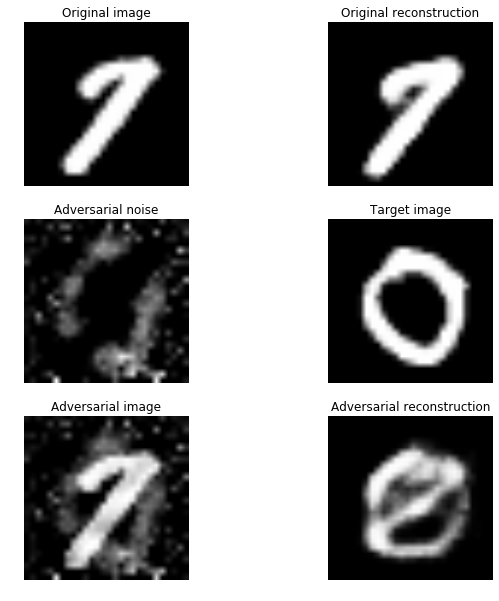

9118 5115 141.323


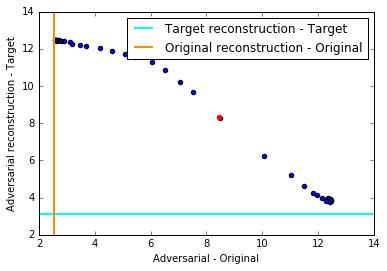

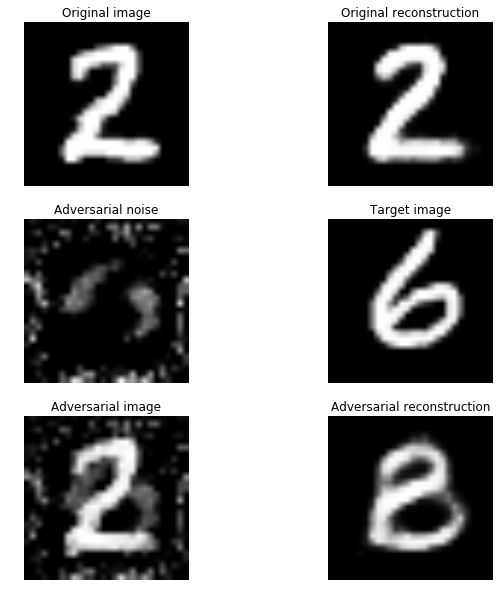

6812 2765 330.234


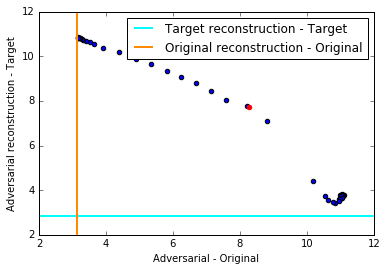

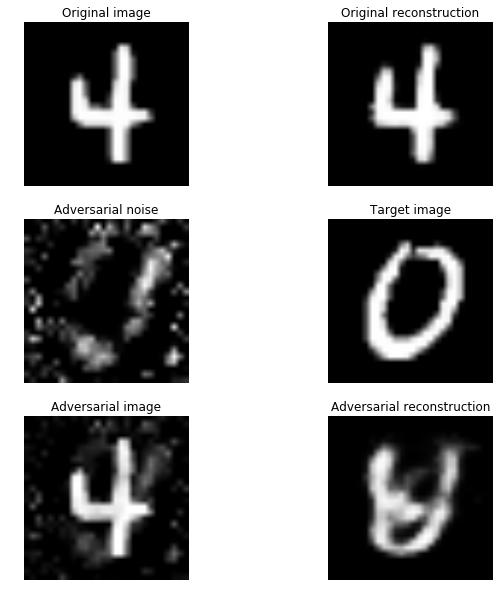

9998 5360 216.032


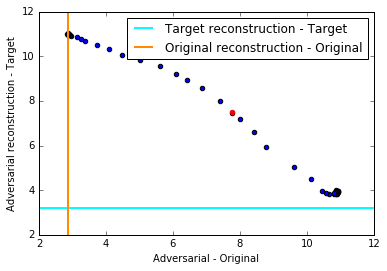

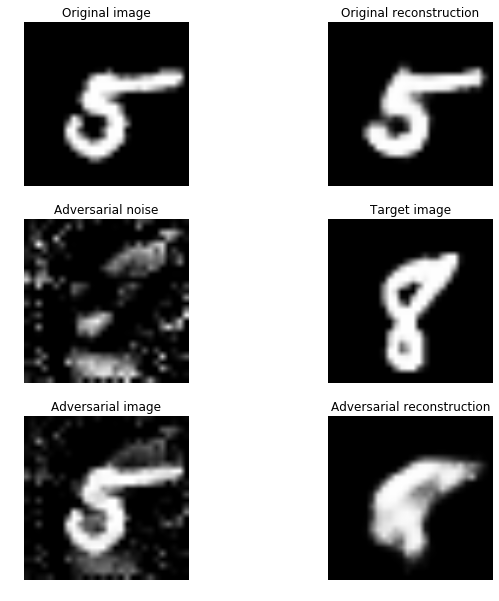

1646 4894 141.323


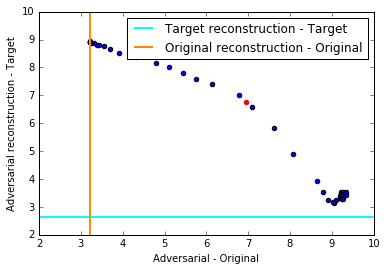

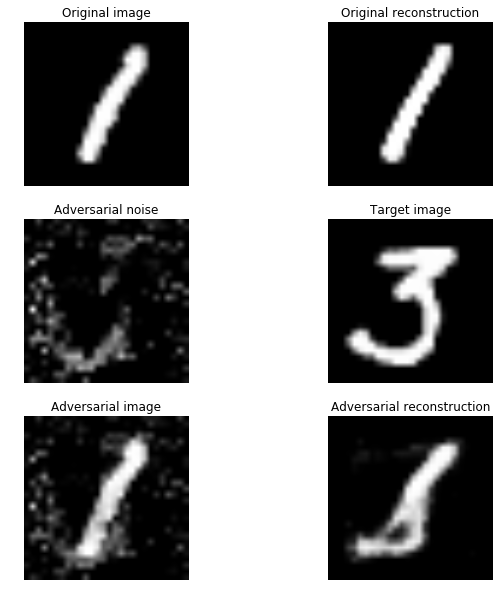

8427 2419 216.032


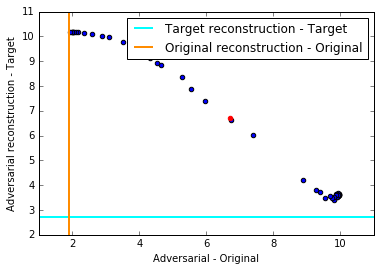

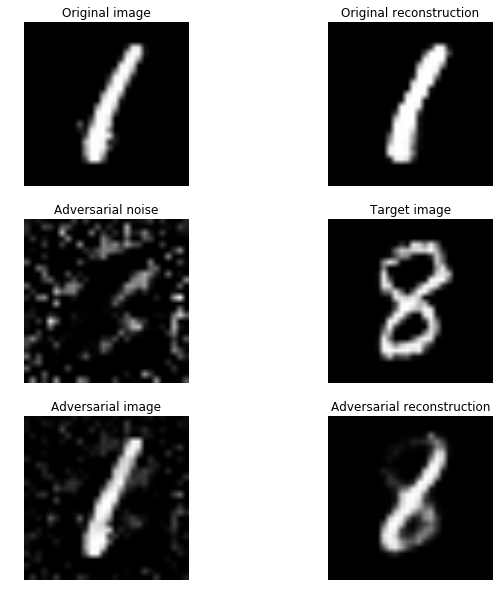

4464 4141 216.032


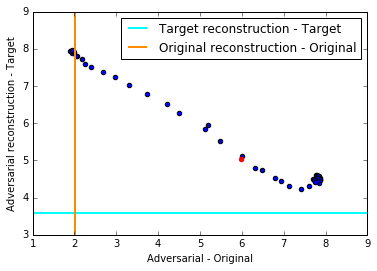

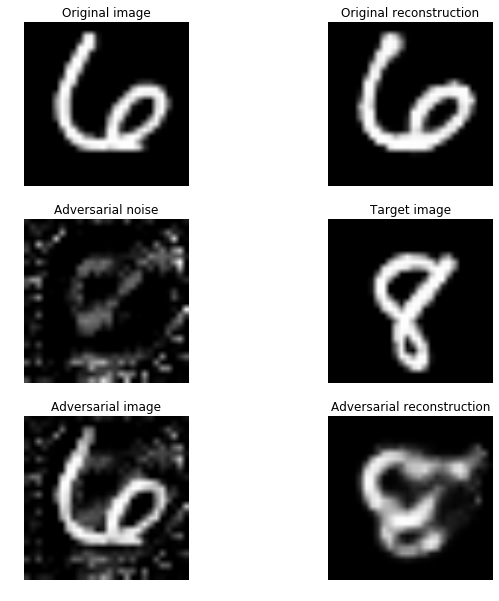

9657 9428 141.323


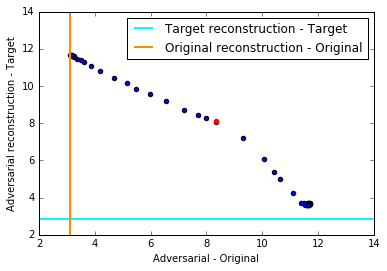

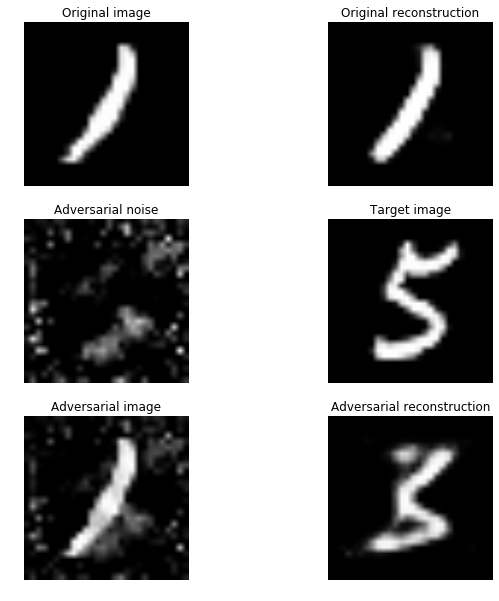

1937 5091 216.032


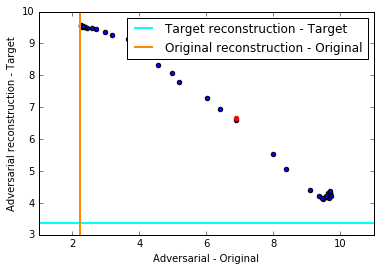

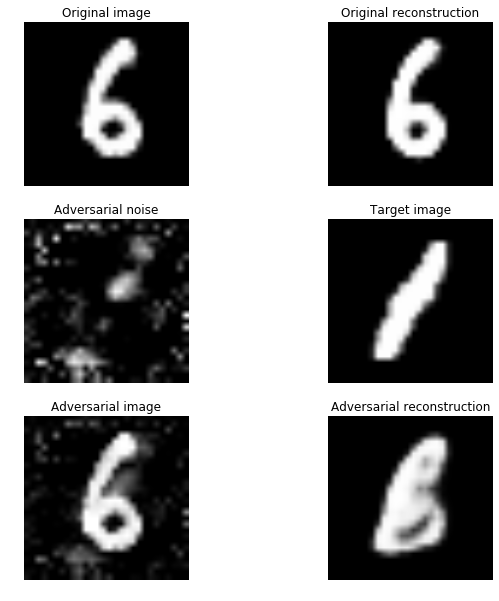

153 2628 330.234


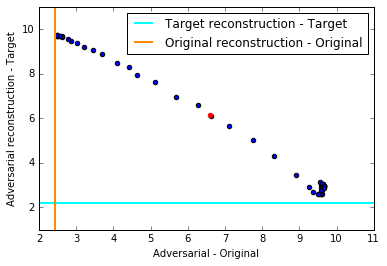

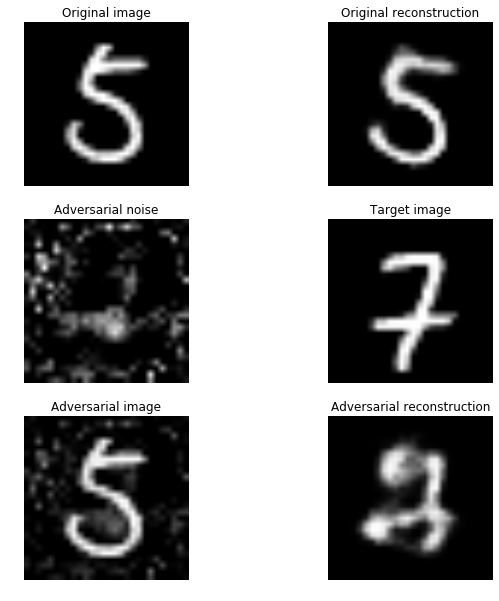

6054 5552 330.234


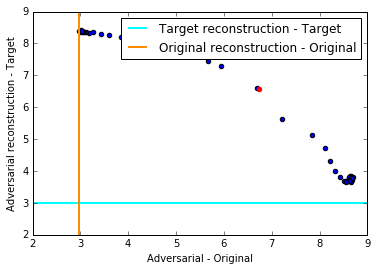

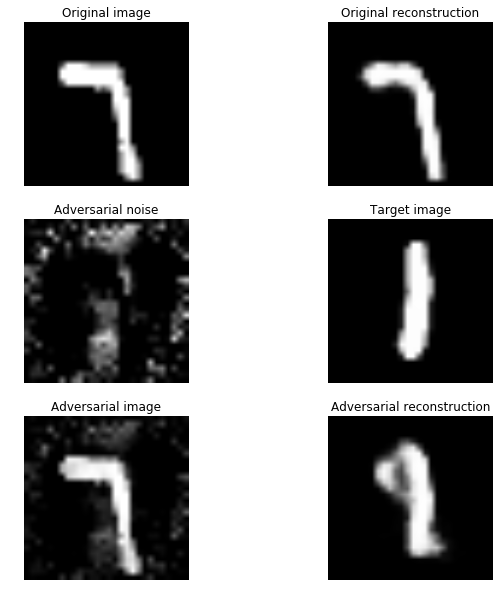

8137 4075 141.323


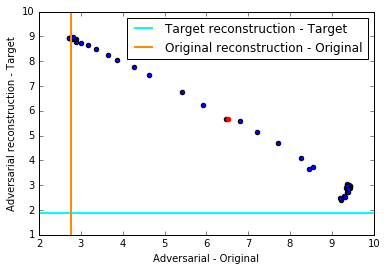

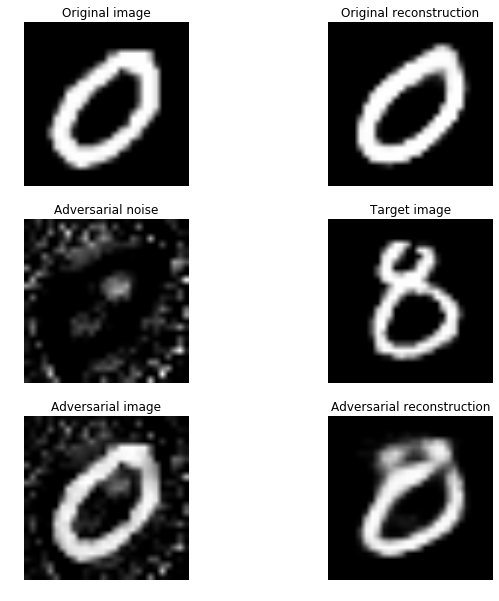

5553 4494 216.032


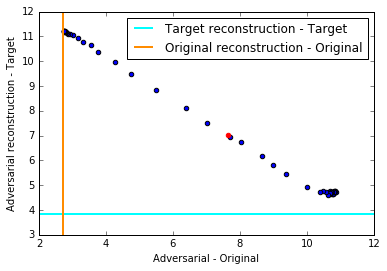

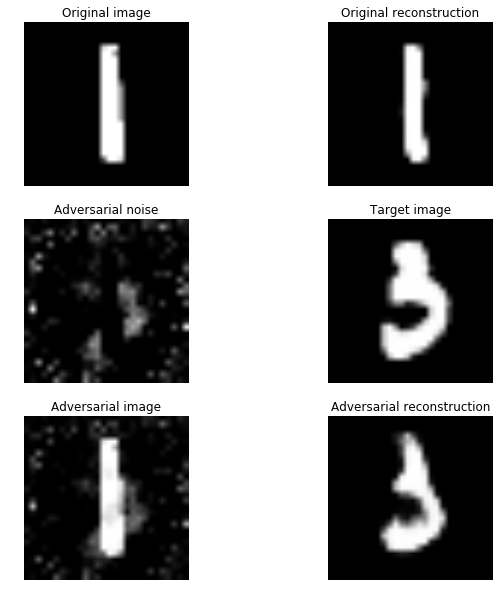

4623 7228 504.808


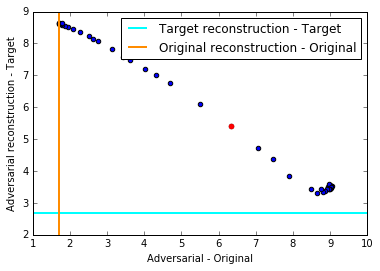

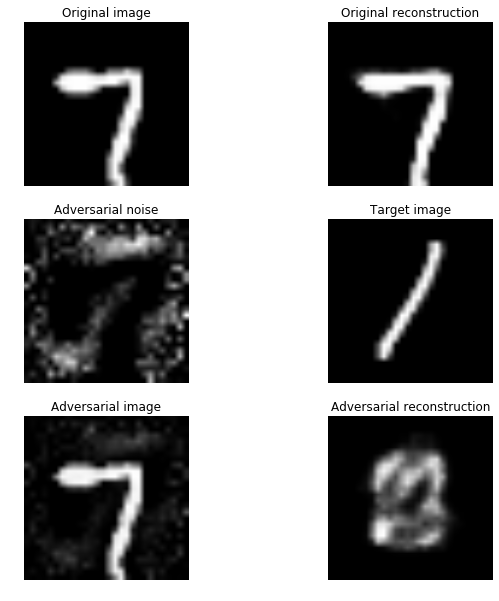

7785 5470 141.323


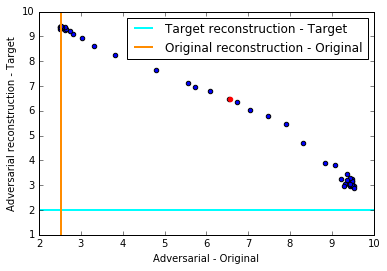

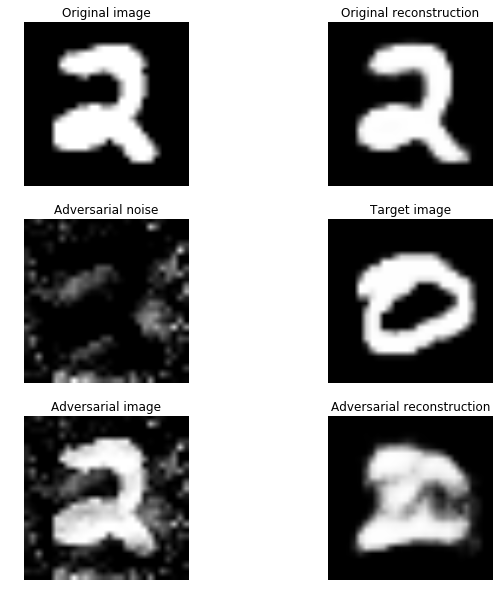

2909 3315 141.323


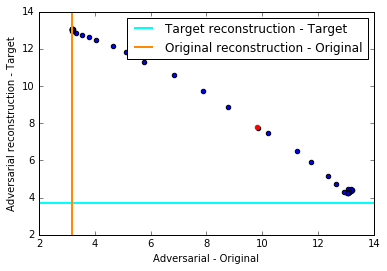

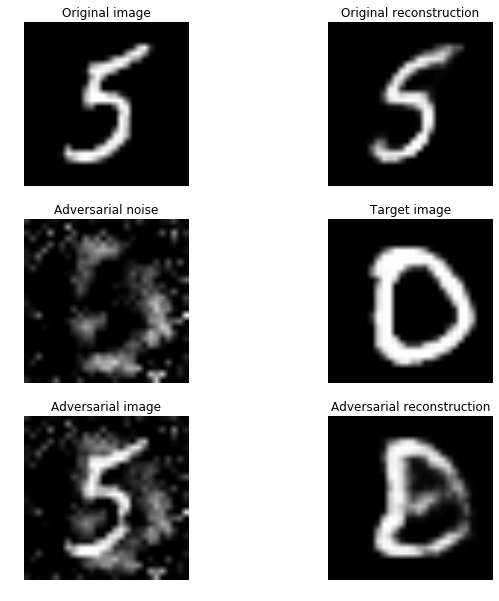

5353 1889 216.032


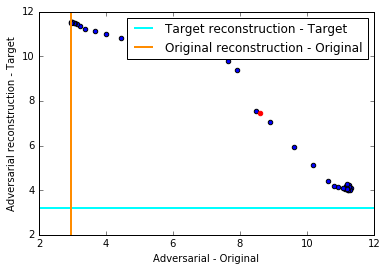

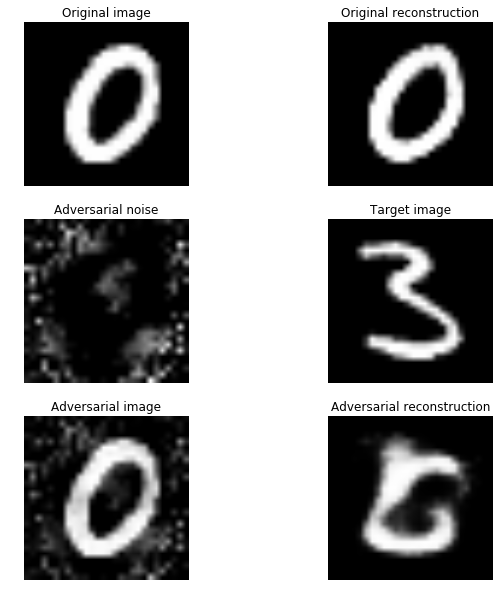

7130 5957 216.032


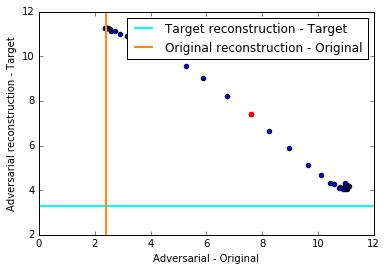

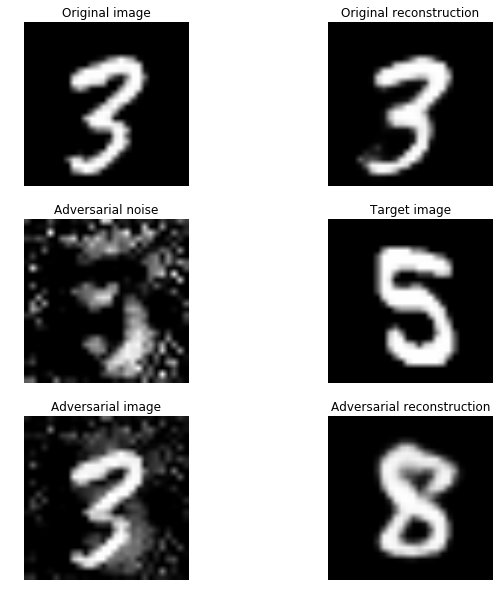

5689 8124 330.234


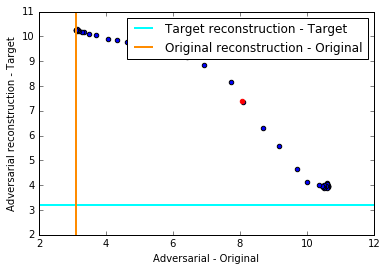

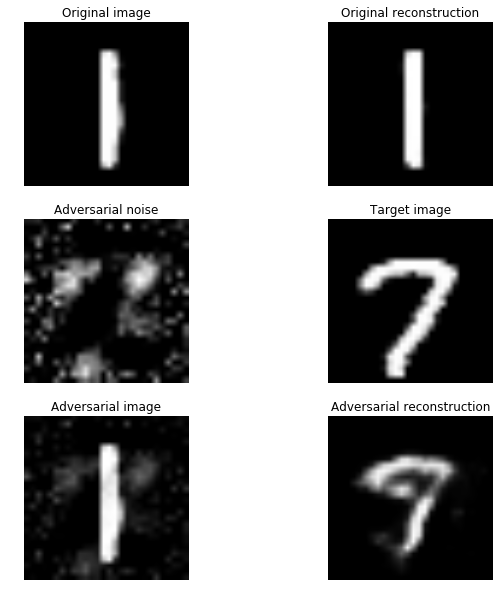

271 4497 330.234


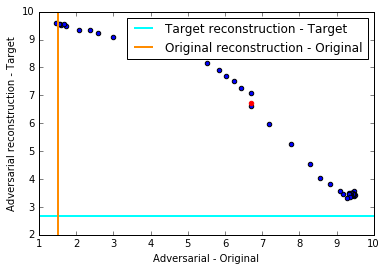

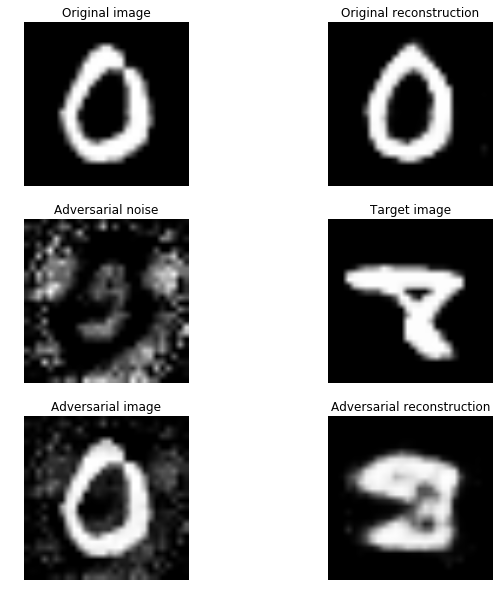

884 7674 330.234


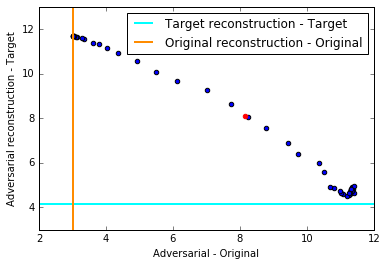

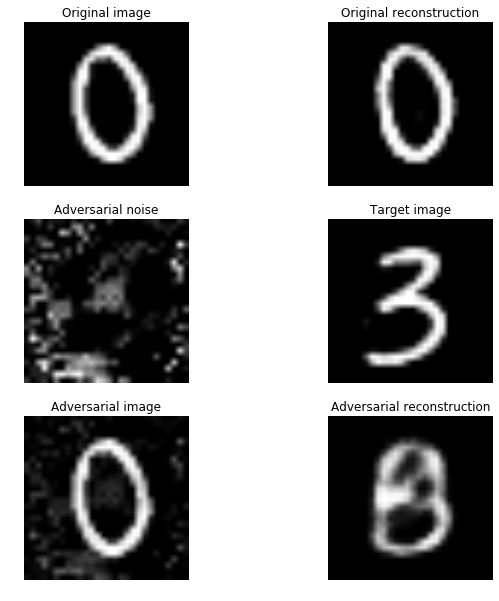

7499 5324 216.032


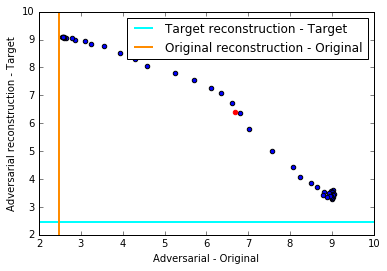

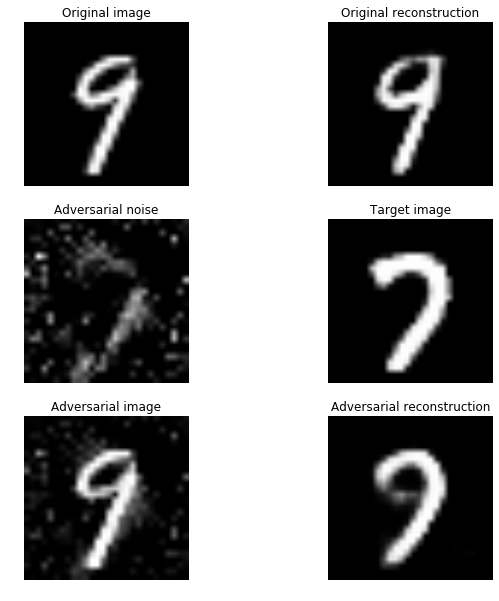

8549 9453 216.032


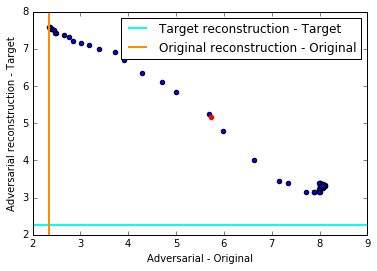

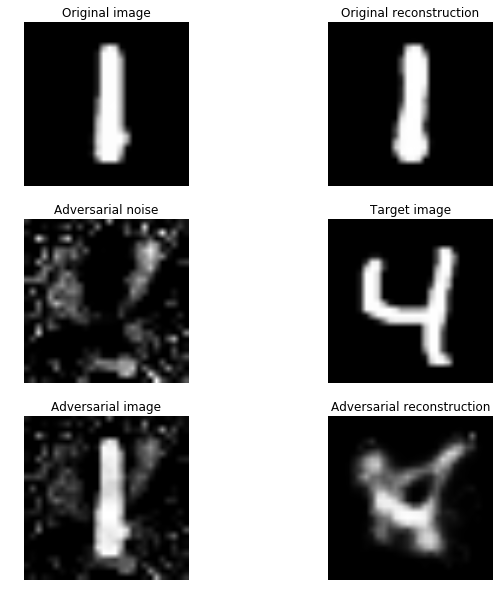

7820 7963 141.323


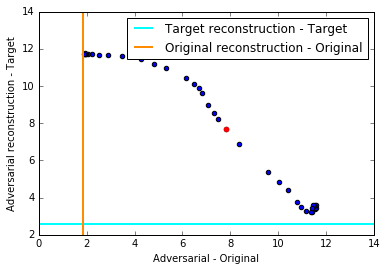

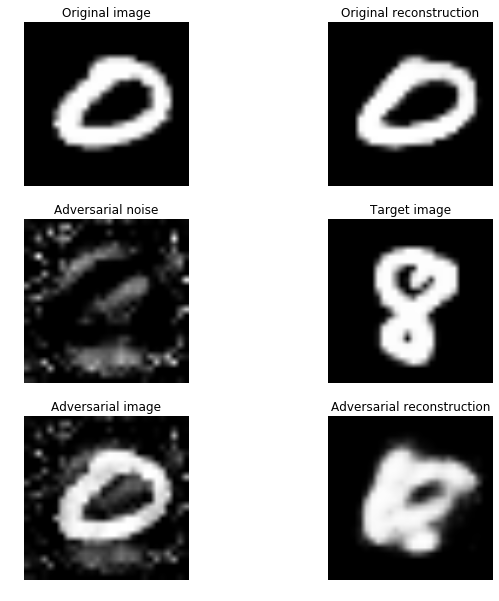

4413 1110 141.323


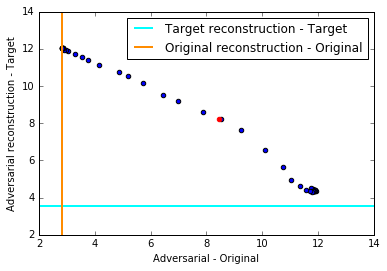

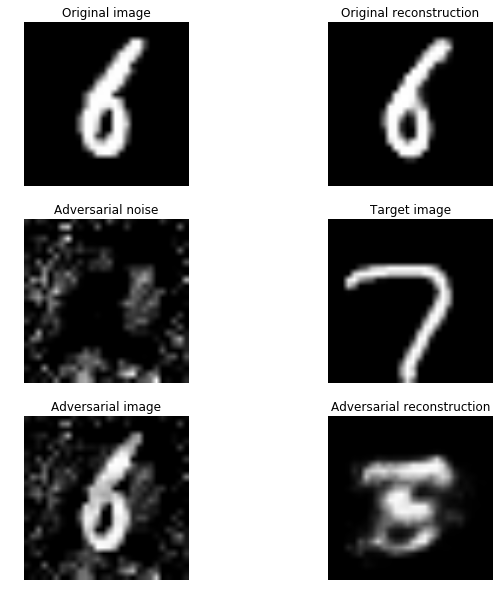

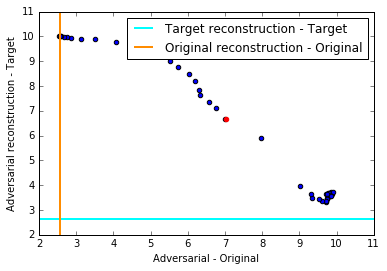

In [13]:
n = 25

xs = []
ys = []
xsds = []
ysds = []

for i in range(n):
    x, y, xsd, ysd = orig_adv_dist(plot = True)
    xs.append(x)
    ys.append(y)
    xsds.append(xsd)
    ysds.append(ysd)
    

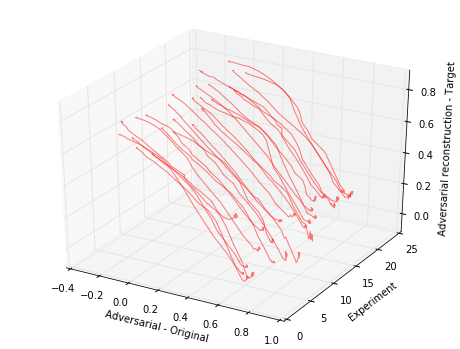

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    ax.plot(xs[i], [i]*len(xs[i]), ys[i], color = 'r', alpha = 0.5)

ax.set_xlabel('Adversarial - Original')
ax.set_ylabel('Experiment')
ax.set_zlabel('Adversarial reconstruction - Target')
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

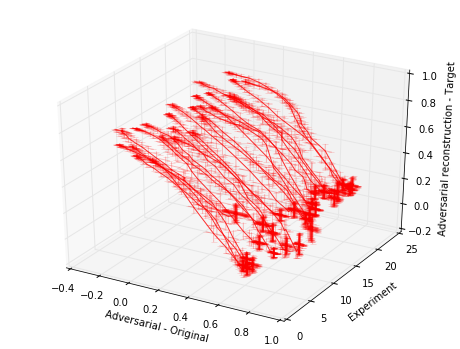

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    ax.plot(xs[i], [i]*len(xs[i]), ys[i], color = 'r', alpha = 0.8)
    
    for j in range(len(xsds[i])):
        x = np.array([xs[i][j], xs[i][j]])
        y = np.array([i, i])
        z = np.array([ys[i][j], ys[i][j]])
        xerror = np.array([-xsds[i][j], xsds[i][j]])
        zerror = np.array([-ysds[i][j], ysds[i][j]])
        ax.plot(x, y, z + zerror, marker="_",color = 'r', alpha = 0.25)
        ax.plot(x + xerror, y, z, marker="_",color = 'r', alpha = 0.25)

ax.set_xlabel('Adversarial - Original')
ax.set_ylabel('Experiment')
ax.set_zlabel('Adversarial reconstruction - Target')
fig.set_figwidth(8)
fig.set_figheight(6)
plt.show()

9791 3405 50


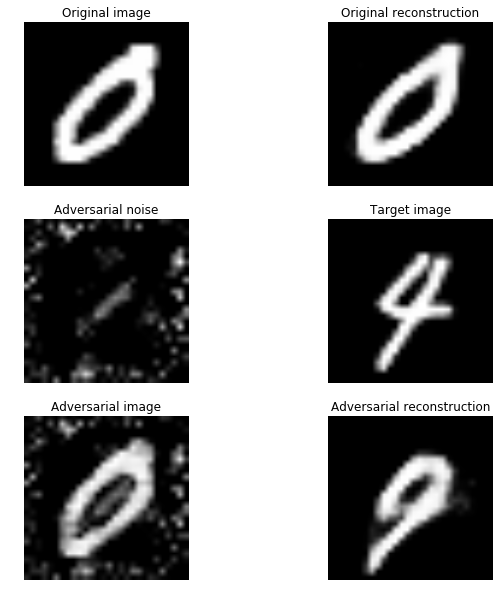

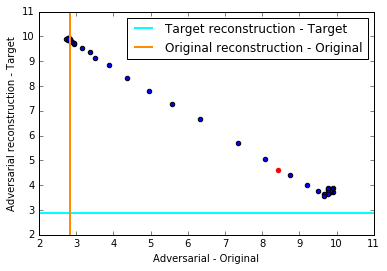

In [16]:
_, _, _, _ = orig_adv_dist(9791, 3405, plot = True, bestC = 50)